# Importazione librerie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Caricamento dataset

In [ ]:
# Load the digits dataset
digits = load_digits()        # variante semplificata di MNIST
X, y = digits.data, digits.target

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))   # da vettore riga a vettore colonna con reshape

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the pixel values
scaler = StandardScaler()  # per evitare che valori piu alti dei pixel siano piu discriminanti
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check shapes of the datasets
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437, 10), (360, 10))

# Esempio di campioni

In [ ]:
def plot_digits(X, y, indices):
    n = len(indices)
    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        img = X[idx].reshape(8, 8)  # Reshape back to 8x8 image
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {y[idx]}')
        plt.axis('off')
    plt.show()

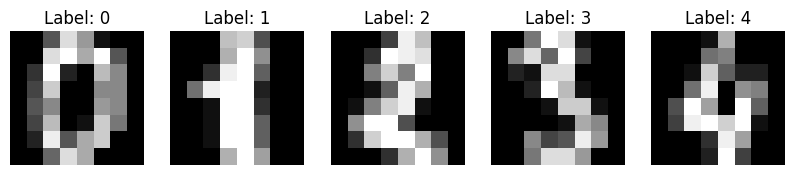

In [ ]:
plot_digits(X, y, range(5))

# Try this
* Implement an MLP from scratch to solve the digit classification problem.

# TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images[0].shape)

# Normalize the images : risultato tra 0 e 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

(28, 28)


In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))  # Flatten the input image : spaghettifica in vettore monodimensionale
model.add(layers.Dense(128, activation='relu'))  # Hidden layer with ReLU activation (Dense sinonimo di fully connected)
model.add(layers.Dense(10, activation='softmax'))  # Output layer with softmax activation

In [ ]:
model.compile(optimizer='adam',  # variante adattativa della dg
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8601 - loss: 0.5044
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9589 - loss: 0.1430
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9727 - loss: 0.0928
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9803 - loss: 0.0680
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9851 - loss: 0.0535


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9701 - loss: 0.0883
Test accuracy: 0.9735000133514404


# Try this
* Convert the above solution into a PyTorch implementation.

# PyTorch

In [4]:
# importazione librerire

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def accuracy(outputs, labels):
    "Confronta le predizioni con le effettiche etichette, e restituisce la % di predizioni corrette"
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)


def train(model, device, train_loader, criterion, optimizer, epoch):
    "Addestramento della Rete Neurale"
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    # ciclo sui batch:  forward -> loss -> backward -> update -> forward -> ...

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        # ogni 200 batch stampa media loss e accuratezza.
        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i+1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0


def test(model, device, test_loader, criterion):
    "Valutazione sul test set"
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}\n')

In [6]:
# iperparametri

batch_size = 64
num_epochs = 10
learning_rate = 0.01

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),    # converte l’immagine in tensor (valori tra 0 e 1)
    transforms.Normalize((0.1307,), (0.3081,))  # normalizza le immagini in base alla media e deviazione standard del dataset MNIST
])


In [8]:
# caricamento dataset
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# immagini 28 x 28

# divisione dei dati in batch per il training e test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in train_loader:
  print(f"Shape of X [N C H W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N C H W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [9]:
# preparazione

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # usa la GPU se disponibile

model = Net().to(device)
print(model)

Net(
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
criterion = nn.CrossEntropyLoss()   # include già la softmax internamente
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# per ogni epoca addestriamo e poi testiamo il modello
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)

Epoch 1, Batch 200, Loss: 1.1029, Accuracy: 0.7642
Epoch 1, Batch 400, Loss: 0.4942, Accuracy: 0.8733
Epoch 1, Batch 600, Loss: 0.3999, Accuracy: 0.8889
Epoch 1, Batch 800, Loss: 0.3578, Accuracy: 0.9005
Test Loss: 0.3074, Test Accuracy: 0.9139

Epoch 2, Batch 200, Loss: 0.3047, Accuracy: 0.9148
Epoch 2, Batch 400, Loss: 0.2950, Accuracy: 0.9142
Epoch 2, Batch 600, Loss: 0.2839, Accuracy: 0.9197
Epoch 2, Batch 800, Loss: 0.2816, Accuracy: 0.9202
Test Loss: 0.2468, Test Accuracy: 0.9306

Epoch 3, Batch 200, Loss: 0.2576, Accuracy: 0.9280
Epoch 3, Batch 400, Loss: 0.2417, Accuracy: 0.9327
Epoch 3, Batch 600, Loss: 0.2374, Accuracy: 0.9343
Epoch 3, Batch 800, Loss: 0.2294, Accuracy: 0.9359
Test Loss: 0.2118, Test Accuracy: 0.9397

Epoch 4, Batch 200, Loss: 0.2106, Accuracy: 0.9405
Epoch 4, Batch 400, Loss: 0.2023, Accuracy: 0.9427
Epoch 4, Batch 600, Loss: 0.2092, Accuracy: 0.9434
Epoch 4, Batch 800, Loss: 0.2035, Accuracy: 0.9407
Test Loss: 0.1882, Test Accuracy: 0.9432

Epoch 5, Batch 2

Probabilità per le immagini mostrate:


Immagine 1 (Etichetta: 7, Predizione: 7)
  Classe 0: 0.0000
  Classe 1: 0.0000
  Classe 2: 0.0004
  Classe 3: 0.0027
  Classe 4: 0.0000
  Classe 5: 0.0000
  Classe 6: 0.0000
  Classe 7: 0.9966
  Classe 8: 0.0000
  Classe 9: 0.0001

Immagine 2 (Etichetta: 2, Predizione: 2)
  Classe 0: 0.0002
  Classe 1: 0.0001
  Classe 2: 0.9954
  Classe 3: 0.0033
  Classe 4: 0.0000
  Classe 5: 0.0003
  Classe 6: 0.0004
  Classe 7: 0.0000
  Classe 8: 0.0003
  Classe 9: 0.0000

Immagine 3 (Etichetta: 1, Predizione: 1)
  Classe 0: 0.0000
  Classe 1: 0.9897
  Classe 2: 0.0036
  Classe 3: 0.0007
  Classe 4: 0.0005
  Classe 5: 0.0008
  Classe 6: 0.0009
  Classe 7: 0.0025
  Classe 8: 0.0012
  Classe 9: 0.0001

Immagine 4 (Etichetta: 0, Predizione: 0)
  Classe 0: 0.9998
  Classe 1: 0.0000
  Classe 2: 0.0001
  Classe 3: 0.0000
  Classe 4: 0.0000
  Classe 5: 0.0000
  Classe 6: 0.0000
  Classe 7: 0.0000
  Classe 8: 0.0000
  Classe 9: 0.0000

Immagine 5 (Etichetta: 4, Prediz

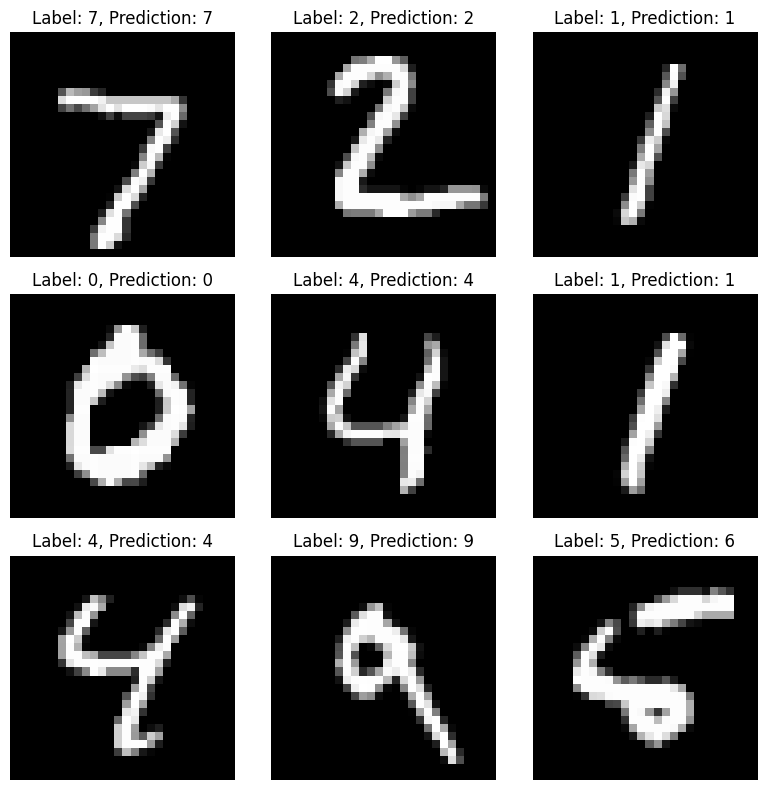

In [12]:
# prendiamo un batch dal test set, effettuiamo le predizioni, e mostriamo l'immagine con l'effettiva etichetta e la predizione effettuata

samples, labels = next(iter(test_loader))  # estraiamo un batch di esempi di test
samples = samples.to(device)  # spostiamo le immagini sulla GPU se disponibile
outputs = model(samples)   # esegue il forward pass del modello
_, preds = torch.max(outputs, 1) # trova la classificazione, ovvero l'indice del valore massimo tra le predizioni

# Calcolo delle probabilità con softmax (solo per visualizzazione)
softmax = torch.nn.Softmax(dim=1)
probs = softmax(outputs)


samples = samples.cpu().numpy()  # per poterle stampare convertiamo le immagini da tensor in vettori numerici numpy per matplot


print("Probabilità per le immagini mostrate:\n")
for idx in range(9):
    print(f"\nImmagine {idx + 1} (Etichetta: {labels[idx]}, Predizione: {preds[idx]})")
    for classe, prob in enumerate(probs[idx]):
        print(f"  Classe {classe}: {prob.item():.4f}")


fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}, Prediction: {preds[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()